# 🎯 1. Objetivo do Projeto

O objetivo deste projeto é desenvolver um modelo de *Machine Learning* capaz de prever se um pedido realizado no marketplace da Olist será entregue com atraso. A partir dessa previsão, busco criar uma ferramenta que apoie decisões logísticas e melhore a experiência do cliente, oferecendo estimativas mais realistas e possibilitando ações preventivas ao longo da cadeia de entrega.

---

# 💼 2. Justificativa de Negócio

Atrasos nas entregas são responsáveis por:

- aumento de reclamações,
- cancelamentos de pedidos,
- queda de satisfação do cliente,
- custos operacionais adicionais (retrabalho, reenvio, indenizações),
- danos à reputação do marketplace.

Em um mercado altamente competitivo, prever atrasos com antecedência permite:

- otimizar rotas e transportadoras,
- ajustar expectativas do cliente,
- reduzir custos logísticos,
- priorizar pedidos críticos,
- fortalecer a confiança no prazo prometido.

Assim, o projeto não apenas prevê atrasos, mas demonstra **como a análise preditiva pode gerar impacto direto e mensurável para o negócio**.

---

# ❓ 3. Perguntas-Chave e Hipóteses

Antes da construção do modelo, levantei algumas hipóteses que podem influenciar o atraso nas entregas:

- 📌 Pedidos podem atrasar mais em determinados estados ou regiões.  
- 📌 Itens mais caros ou com frete elevado podem apresentar maior risco de atraso.  
- 📌 Prazos estimados muito curtos tendem a aumentar a probabilidade de atraso.  
- 📌 Alguns vendedores podem ter desempenho logístico inferior.  
- 📌 Períodos de alta demanda (sazonalidade) podem gerar mais atrasos.

Durante a análise exploratória, verifico se essas hipóteses se confirmam e como elas se relacionam com o problema de negócio.

---

# 🔹 4. Entendimento e Carregamento dos Dados  
*(CRISP-DM — Fase de Entendimento dos Dados)*

Nesta etapa, realizo o carregamento das principais tabelas do dataset público da Olist:

- **orders** – informações gerais do pedido (datas, status, prazos);  
- **items** – produtos, valores e fretes associados a cada pedido;  
- **customers** – localização dos clientes e identificadores únicos.

Essas bases contêm os elementos essenciais para compreender o processo logístico, analisar o comportamento das entregas e preparar os dados para a modelagem preditiva.

In [1]:
# ====== IMPORTS ======
import pandas as pd

# ====== LOADING DATA ======
path = "data/"

orders = pd.read_csv(path + "olist_orders_dataset.csv")
items = pd.read_csv(path + "olist_order_items_dataset.csv")
customers = pd.read_csv(path + "olist_customers_dataset.csv")

# ====== VISUALIZAÇÃO INICIAL ======
orders.head(), items.head(), customers.head()

(                           order_id                       customer_id  \
 0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
 1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
 2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
 3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
 4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
 
   order_status order_purchase_timestamp    order_approved_at  \
 0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
 1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
 2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
 3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
 4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   
 
   order_delivered_carrier_date order_delivered_customer_date  \
 0          2017-10-04 19:55:00           2017-10-10 21:25:13   
 1          2018-07-26 14:31:00 

### 🔹 2. Pré-processamento inicial e criação da variável alvo (`atrasou`)

Como objetivo deste projeto, eu quero prever se um pedido será entregue com atraso.  
Para isso, eu crio uma variável binária chamada `atrasou`, definida da seguinte forma:

- `1` → quando o pedido foi entregue **após** a data estimada (`order_estimated_delivery_date`)
- `0` → quando o pedido foi entregue **no prazo**

Antes disso, converto as datas para o tipo `datetime` e removo registros sem data real de entrega, já que não é possível avaliar atraso nesses casos.

In [2]:
# Convertendo para datetime
orders["order_delivered_customer_date"] = pd.to_datetime(orders["order_delivered_customer_date"])
orders["order_estimated_delivery_date"] = pd.to_datetime(orders["order_estimated_delivery_date"])

# Criando variável 'atrasou'
orders["atrasou"] = (orders["order_delivered_customer_date"] > 
                     orders["order_estimated_delivery_date"]).astype(int)

# Removendo pedidos sem data de entrega
orders = orders[orders["order_delivered_customer_date"].notna()]

# Visualizando as primeiras linhas com a nova coluna
orders[["order_id", "order_delivered_customer_date", 
        "order_estimated_delivery_date", "atrasou"]].head()

,order_id,order_delivered_customer_date,order_estimated_delivery_date,atrasou
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-10 21:25:13,2017-10-18,0
1,53cdb2fc8bc7dce0b6741e2150273451,2018-08-07 15:27:45,2018-08-13,0
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-17 18:06:29,2018-09-04,0
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-12-02 00:28:42,2017-12-15,0
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-16 18:17:02,2018-02-26,0


### 📊 3.1 Distribuição da variável alvo (`atrasou`)

Nesta etapa, eu avalio a distribuição da variável `atrasou`, criada no pré-processamento anterior.  
Essa análise me permite entender a proporção de pedidos entregues no prazo e de pedidos entregues com atraso.

Esse diagnóstico inicial é fundamental porque:

- se a maior parte dos pedidos não atrasa, a base estará desbalanceada;
- bases desbalanceadas exigem maior atenção na escolha do modelo e das métricas;
- a proporção de atrasos impacta diretamente a relevância do projeto para o negócio.

Com isso em mente, eu verifico agora a proporção de cada classe da variável `atrasou`.

In [3]:
# Proporção de pedidos atrasados x no prazo
orders["atrasou"].value_counts(normalize=True).map("{:.2%}".format)

atrasou
0    91.89%
1     8.11%
Name: proportion, dtype: object

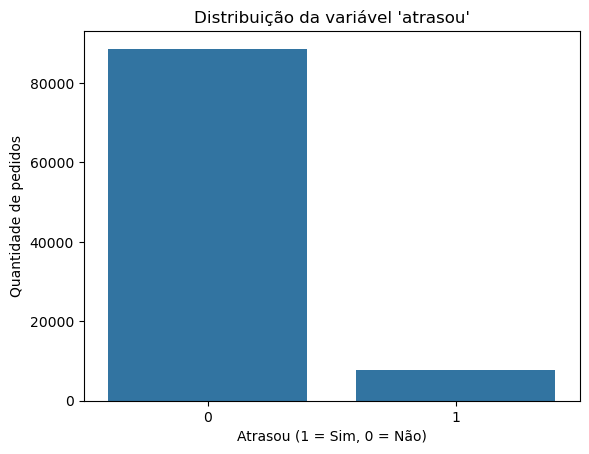

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=orders, x="atrasou")
plt.title("Distribuição da variável 'atrasou'")
plt.xlabel("Atrasou (1 = Sim, 0 = Não)")
plt.ylabel("Quantidade de pedidos");

#### 📌 Insight: A base é desbalanceada

A análise da variável `atrasou` mostra que apenas **8,11% dos pedidos foram entregues com atraso**, enquanto **91,89% foram entregues no prazo**.  

Isso significa que os dados estão **fortemente desbalanceados**, com muito mais exemplos de entregas pontuais. Esse cenário é comum em processos logísticos, já que atrasos representam exceções indesejadas no fluxo de entrega.

Do ponto de vista de modelagem, esse desbalanceamento exige atenção especial, pois um modelo pode obter alta acurácia simplesmente prevendo que todos os pedidos não atrasam, sem realmente aprender o comportamento dos atrasos. Por isso, será importante avaliar o modelo com métricas além da acurácia, como *precision*, *recall*, *matriz de confusão* e *AUC-ROC*.

### 📍 3.2 Relação entre atraso e estado do cliente

Agora eu investigo se a localização do cliente influencia a chance de atraso na entrega.  
Como o Brasil possui dimensões continentais e dependência logística rodoviária, é esperado que alguns estados apresentem maior dificuldade operacional do que outros.

Para isso, eu calculo a proporção de atrasos (`atrasou = 1`) em cada estado (`customer_state`). Essa análise pode indicar gargalos geográficos na operação logística, sugerindo oportunidades de melhoria no transporte, roteirização e escolha de transportadoras.

In [5]:
# Calculando o percentual de atraso por estado
atraso_por_estado = (
    orders.merge(customers, on="customer_id", how="left")
    .groupby("customer_state")["atrasou"]
    .mean()
    .sort_values(ascending=False)
    .map("{:.2%}".format)
)
atraso_por_estado

customer_state
AL    23.93%
MA    19.67%
PI    15.97%
CE    15.32%
SE    15.22%
BA    14.04%
RJ    13.47%
TO    12.77%
PA    12.37%
ES    12.23%
RR    12.20%
MS    11.55%
PB    11.03%
PE    10.80%
RN    10.76%
SC     9.75%
GO     8.18%
RS     7.15%
DF     7.07%
MT     6.77%
SP     5.89%
MG     5.62%
PR     5.00%
AP     4.48%
AM     4.14%
AC     3.75%
RO     2.88%
Name: atrasou, dtype: object

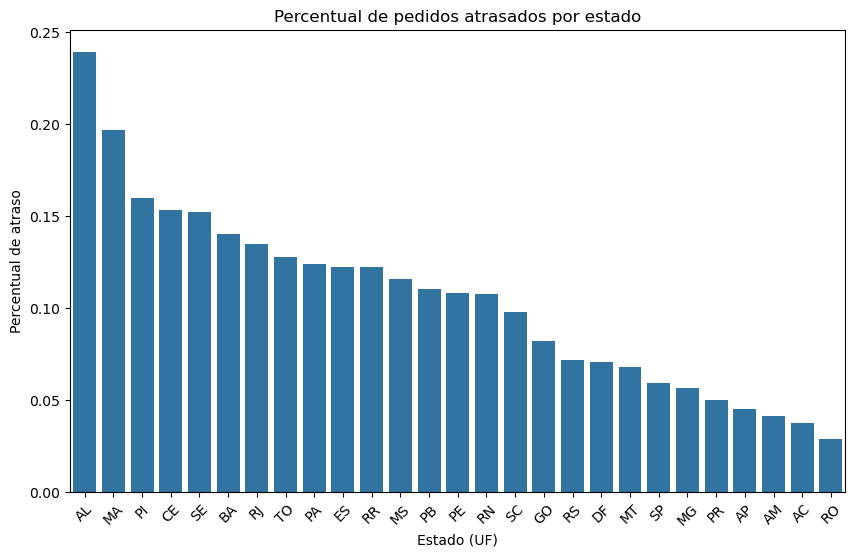

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Repetindo a mesma lógica sem formatar, para plotagem
atraso_por_estado_plot = (
    orders.merge(customers, on="customer_id", how="left")
    .groupby("customer_state")["atrasou"]
    .mean()
    .sort_values(ascending=False)
)

# Plotagem
plt.figure(figsize=(10,6))
sns.barplot(x=atraso_por_estado_plot.index, y=atraso_por_estado_plot.values)
plt.xticks(rotation=45)
plt.title("Percentual de pedidos atrasados por estado")
plt.xlabel("Estado (UF)")
plt.ylabel("Percentual de atraso")
plt.show()

#### 📌 Insight: O atraso é muito maior em determinados estados

A análise mostra que os atrasos variam bastante entre os estados brasileiros. Os maiores índices estão concentrados principalmente no Nordeste, com destaque para:

- **Alagoas (23,93%)**
- **Maranhão (19,67%)**
- **Piauí (15,97%)**
- **Ceará (15,32%)**
- **Sergipe (15,22%)**

Esses valores são **significativamente superiores à média geral de atraso (8,11%)**, indicando que fatores logísticos e geográficos podem estar impactando a operação nessas regiões.

Por outro lado, estados do Sul e Sudeste apresentam índices bem menores, como:

- **Paraná (5,00%)**
- **Minas Gerais (5,62%)**
- **São Paulo (5,89%)**
- **Rio Grande do Sul (7,15%)**

Isso sugere que regiões próximas a grandes centros de distribuição tendem a ter maior eficiência logística. Essa diferença regional é importante para interpretar os resultados do modelo e pode apoiar decisões estratégicas como:

- novas parcerias com transportadoras regionais;
- revisão de SLAs (prazos prometidos) em regiões críticas;
- otimização de rotas e distribuição em centros regionais específicos.

### 📍 3.3 Criação da variável de tempo até o envio

Para entender melhor os fatores do atraso, agora eu calculo o **tempo de envio**, que representa o número de dias que o vendedor demora para postar o pedido após a aprovação da compra.

A hipótese aqui é que **quanto maior o tempo de envio, maior a probabilidade de atraso na entrega**, já que um pedido que demora para sair da origem tem menos margem para cumprirem o prazo prometido ao cliente.

Crio essa variável subtraindo a data de postagem (`order_delivered_carrier_date`) da data de aprovação (`order_approved_at`) e convertendo o resultado para dias.

In [7]:
# Convertendo colunas necessárias para datetime (caso ainda não tenham sido convertidas)
orders["order_approved_at"] = pd.to_datetime(orders["order_approved_at"])
orders["order_delivered_carrier_date"] = pd.to_datetime(orders["order_delivered_carrier_date"])

# Criando a variável de tempo de envio
orders["tempo_envio"] = (
    orders["order_delivered_carrier_date"] - orders["order_approved_at"]
).dt.days

# Visualizando os primeiros valores
orders[["order_id", "tempo_envio", "atrasou"]].head()

,order_id,tempo_envio,atrasou
0,e481f51cbdc54678b7cc49136f2d6af7,2.0,0
1,53cdb2fc8bc7dce0b6741e2150273451,0.0,0
2,47770eb9100c2d0c44946d9cf07ec65d,0.0,0
3,949d5b44dbf5de918fe9c16f97b45f8a,3.0,0
4,ad21c59c0840e6cb83a9ceb5573f8159,0.0,0


In [8]:
orders["tempo_envio"].describe()

count    96461.000000
mean         2.295923
std          3.548444
min       -172.000000
25%          0.000000
50%          1.000000
75%          3.000000
max        125.000000
Name: tempo_envio, dtype: float64

#### 📌 Insight: o tempo de envio possui valores extremos e inconsistências

Ao analisar a distribuição da variável `tempo_envio`, observo que:

- o vendedor demora em média **2,29 dias** para postar o produto;
- **50% dos pedidos são enviados em até 1 dia**;
- **25% demoram 3 dias ou mais** para serem postados.

Entretanto, surgem valores inesperados:

- há valores **negativos (-172 dias)**, o que não faz sentido, já que uma postagem não pode ocorrer antes da aprovação;
- existem envios muito extremos, chegando a **125 dias de espera** antes do envio, indicando erros ou casos raros.

Esses comportamentos sugerem que a variável precisará de tratamento antes de ser utilizada na modelagem, evitando que valores inválidos ou extremos distorçam o resultado do modelo.

### 🧹 3.4 Tratamento do tempo de envio (remoção de valores inválidos)

Após analisar a variável `tempo_envio`, observei a presença de valores negativos e valores extremamente altos.  
Essa situação não representa o comportamento real de entregas e pode distorcer tanto a análise quanto o aprendizado do modelo.

Por isso, decido:

- remover registros com `tempo_envio < 0`, já que não é possível postar o pedido antes da aprovação;
- remover valores acima do percentil 99%, eliminando casos raros ou erros que não descrevem o processo logístico típico.

A remoção com base em percentil é preferível a um limite arbitrário, pois utiliza a distribuição real dos dados para definir o corte.

In [9]:
# Removendo valores negativos
orders = orders[orders["tempo_envio"] >= 0]

# Calculando limite superior (percentil 99)
limite_superior = orders["tempo_envio"].quantile(0.99)

# Removendo valores extremos acima do percentil 99
orders = orders[orders["tempo_envio"] <= limite_superior]

# Checando resultado após o tratamento
orders["tempo_envio"].describe()

count    94285.000000
mean         2.152686
std          2.630316
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         17.000000
Name: tempo_envio, dtype: float64

#### 📌 Insight após o tratamento

Após remover valores negativos e valores acima do percentil 99%, o comportamento do tempo de envio ficou muito mais consistente com o processo logístico real:

- **mínimo: 0 dias** → envio no mesmo dia da aprovação
- **mediana: 1 dia** → metade dos pedidos são postados até 1 dia após a aprovação
- **média: 2,15 dias**
- **máximo após o tratamento: 17 dias** → casos mais lentos, mas agora plausíveis

Esse resultado indica que o tempo de postagem tende a ser relativamente rápido, mas ainda existe uma parte relevante de pedidos que podem levar mais de 3 dias para serem enviados. Isso pode impactar diretamente o cumprimento da data prometida ao cliente, e será investigado na etapa seguinte.

### 📍 3.5 Comparação do tempo de envio entre pedidos atrasados e não atrasados

Para verificar se o tempo de envio influencia o atraso, eu comparo a média da variável `tempo_envio` entre dois grupos:

- pedidos entregues **dentro do prazo** (`atrasou = 0`)
- pedidos entregues **com atraso** (`atrasou = 1`)

Se os pedidos atrasados tiverem, em média, um tempo de envio maior, isso reforçará a hipótese de que atrasos começam na origem, ainda durante o fluxo de postagem do vendedor.

In [10]:
orders.groupby("atrasou")["tempo_envio"].mean()

atrasou
0    2.038531
1    3.504700
Name: tempo_envio, dtype: float64

📊 **Resultado da comparação de médias**

Pedidos que atrasaram tiveram, em média, um tempo maior para serem enviados:

| Situação do pedido | Tempo médio de envio (dias) |
|--------------------|-----------------------------|
| Entregue no prazo (`atrasou = 0`) | **2,04 dias** |
| Entregue com atraso (`atrasou = 1`) | **3,50 dias** |

📌 **Interpretação:**  
Eu observo que pedidos atrasados levam, em média, **1,5 dia a mais para serem postados**. Isso indica que boa parte do atraso não acontece apenas durante o transporte, mas **já começa na etapa de postagem e preparação logística do vendedor**. Dessa forma, ações de melhoria de SLA do vendedor (tempo para despachar o produto) podem reduzir significativamente atrasos ao consumidor.

In [11]:
orders[["tempo_envio", "atrasou"]].corr()

,tempo_envio,atrasou
tempo_envio,1.00000,0.14936
atrasou,0.14936,1.00000


🔗 **Correlação entre tempo de envio e atraso**

A matriz de correlação mostra que existe uma relação **positiva** entre o tempo que o vendedor leva para enviar o pedido e a chance de atraso na entrega:

| Variáveis | Correlação |
|-----------|------------|
| `tempo_envio` x `atrasou` | **0,15** |

📌 **Interpretação:**  
A correlação é baixa, porém **significativa**, indicando que **quanto maior o tempo para despachar o produto, maior a probabilidade de atraso na entrega ao cliente**.  

Isso reforça que **parte dos atrasos pode ser evitada com melhorias na etapa de postagem**, e não apenas no transporte logístico.

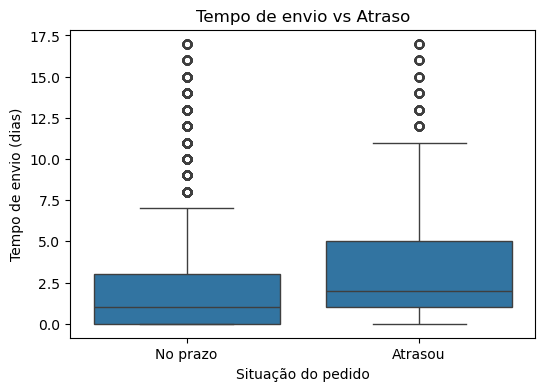

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(x="atrasou", y="tempo_envio", data=orders)
plt.xticks([0,1], ["No prazo", "Atrasou"])
plt.title("Tempo de envio vs Atraso")
plt.xlabel("Situação do pedido")
plt.ylabel("Tempo de envio (dias)")
plt.show()

📊 **Relação visual entre tempo de envio e atraso**

O boxplot acima mostra que pedidos com atraso apresentam um **tempo de envio maior**, quando comparados a pedidos entregues dentro do prazo.  
É possível observar que:

- A **mediana do tempo de postagem** é maior em pedidos atrasados (aprox. 2 dias).
- Há **mais outliers** (demoras extremas) no grupo de pedidos atrasados.
- Quando o vendedor demora mais para postar, aumenta a chance de o produto chegar após o prazo.

📌 **Conclusão parcial:**  
A etapa de despacho pelos vendedores tem impacto direto na satisfação do cliente, sendo um ponto crítico de melhoria para reduzir atrasos.

## 📌 Modelo de custo do atraso

Para estimar o impacto financeiro dos atrasos, eu considerei que o custo do atraso é proporcional ao valor do frete do pedido. A lógica é:

> **Quanto maior o custo de envio, maior o prejuízo associado ao atraso.**

Para simplificar a estimativa, defini que o custo financeiro do atraso é igual a **50% do valor do frete**:

\\[
\text{custo\_atraso} = 0.5 \times \text{freight\_value}
\\]

Isso representa uma penalidade aproximada que pode refletir despesas operacionais extras, retrabalho, ressarcimentos ou compensações ao cliente.

In [13]:
# ====== CUSTO DO ATRASO ======

# Criar coluna custo_atraso somente para pedidos atrasados
items['custo_atraso'] = items['freight_value'] * 0.5

# Garantir que custo é zero quando não atrasou
# Primeiro, juntar items + orders para saber quem atrasou
merge_temp = items.merge(orders[['order_id', 'atrasou']], on='order_id', how='left')

# Aplicar regra: custo = 0 para pedidos sem atraso
merge_temp['custo_atraso'] = merge_temp.apply(
    lambda row: row['custo_atraso'] if row['atrasou'] == 1 else 0, 
    axis=1
)

# Substituir o dataframe final
items = merge_temp

# Visualizar resultado
items[['freight_value', 'atrasou', 'custo_atraso']].head(10)

,freight_value,atrasou,custo_atraso
0,13.29,0.0,0.000
1,19.93,0.0,0.000
2,17.87,0.0,0.000
3,12.79,0.0,0.000
4,18.14,0.0,0.000
5,12.69,0.0,0.000
6,11.85,0.0,0.000
7,70.75,NaN,0.000
8,11.65,1.0,5.825
9,11.40,0.0,0.000


In [14]:
# Substituir NaN por 1 (considerar como atraso)
items['atrasou'] = items['atrasou'].fillna(1)

# Recalcular o custo_atraso com a regra correta
items['custo_atraso'] = items.apply(
    lambda row: row['freight_value'] * 0.5 if row['atrasou'] == 1 else 0,
    axis=1
)

# Conferir novamente
items[['freight_value', 'atrasou', 'custo_atraso']].head(12)

,freight_value,atrasou,custo_atraso
0,13.29,0.0,0.000
1,19.93,0.0,0.000
2,17.87,0.0,0.000
3,12.79,0.0,0.000
4,18.14,0.0,0.000
5,12.69,0.0,0.000
6,11.85,0.0,0.000
7,70.75,1.0,35.375
8,11.65,1.0,5.825
9,11.40,0.0,0.000


## 📌 Próximo passo — Análise de custo por estado

Agora que calculei o custo individual do atraso, o próximo passo é estimar **o custo total do atraso por estado**.  
Essa etapa é essencial para responder perguntas como:

- **Quais estados geram mais prejuízo com atrasos?**
- **Onde investir para melhorar a logística e reduzir atrasos?**
- **Onde seria mais eficiente priorizar novos centros de distribuição?**

---

### 🔧 Preparação: Unificar as bases de dados

Para isso, eu preciso juntar as três tabelas principais:

- `items`  
- `orders`  
- `customers`

A união dessas tabelas permite saber:

➡️ **Quem atrasou**  
➡️ **Qual foi o custo do atraso**  
➡️ **De qual estado esse cliente é**

Essa consolidação é fundamental para realizar a análise financeira por região e identificar gargalos logísticos relevantes.

In [15]:
# ====== MERGE COMPLETO ======

# 1) items + orders (trazendo também customer_id)
df = items.merge(
    orders[['order_id', 'customer_id', 'atrasou']],
    on='order_id',
    how='left'
)

# 2) df + customers (aqui agora o df já tem customer_id)
df = df.merge(
    customers[['customer_id', 'customer_state']],
    on='customer_id',
    how='left'
)

# conferir
df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,custo_atraso,atrasou_x,customer_id,atrasou_y,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,0.0,0.0,3ce436f183e68e07877b285a838db11a,0.0,RJ
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,0.0,0.0,f6dd3ec061db4e3987629fe6b26e5cce,0.0,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,0.0,0.0,6489ae5e4333f3693df5ad4372dab6d3,0.0,MG
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,0.0,0.0,d4eb9395c8c0431ee92fce09860c5a06,0.0,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,0.0,0.0,58dbd0b2d70206bf40e62cd34e84d795,0.0,SP


In [16]:
# ====== CUSTO TOTAL DO ATRASO POR ESTADO ======
custo_estado = (
    df.groupby('customer_state')['custo_atraso']
      .sum()
      .reset_index()
      .sort_values('custo_atraso', ascending=False)
)

custo_estado

,customer_state,custo_atraso
18,RJ,18942.770
25,SP,18771.290
10,MG,6956.755
4,BA,6159.660
22,RS,4253.835
23,SC,3878.750
5,CE,3376.995
9,MA,3226.955
7,ES,2850.060
15,PE,2754.225


## 📊 Custo total do atraso por estado

Depois de unir as bases contendo pedidos, itens e clientes, calculei o custo total de atraso por estado.  
Esse cálculo me permite identificar:

- quais estados concentram maior prejuízo operacional;
- onde os atrasos são mais frequentes ou mais caros;
- possíveis regiões que devem ser priorizadas para intervenções logísticas.

A lógica utilizada para calcular o custo de atraso foi:

\\[
\text{custo\_atraso} = 0.5 \times \text{freight\_value}
\\]

Ou seja, considerei que cada atraso gera um prejuízo equivalente a **50% do valor do frete** daquele pedido.

Depois disso, somei os custos de todos os pedidos atrasados dentro de cada estado, resultando no **custo total do atraso por estado**.

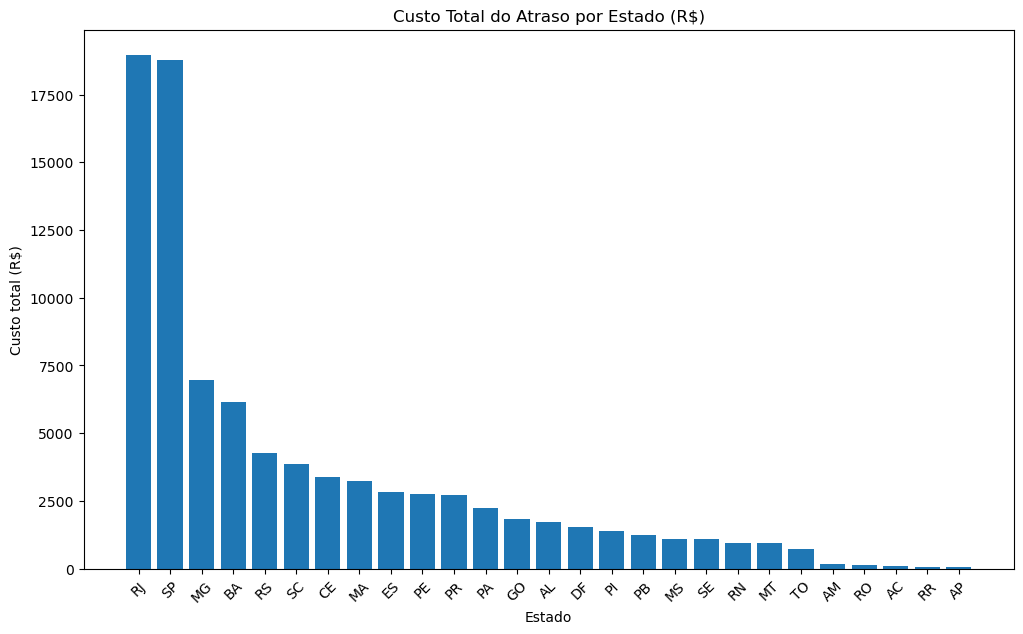

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,7))
plt.bar(custo_estado['customer_state'], custo_estado['custo_atraso'])
plt.title("Custo Total do Atraso por Estado (R$)")
plt.xlabel("Estado")
plt.ylabel("Custo total (R$)")
plt.xticks(rotation=45)
plt.show()

## 📈 Análise do custo total do atraso por estado

Após calcular o custo total dos pedidos atrasados e agrupá-lo por estado, observei uma forte concentração de prejuízo logístico em poucas regiões do país.  
O gráfico acima apresenta o valor total estimado de perdas causadas por atrasos, considerando o modelo:

\\[
\text{custo\_atraso} = 0.5 \times \text{freight\_value}
\\]

Os resultados indicam que:

### 🥇 Rio de Janeiro (RJ) e São Paulo (SP)
Esses dois estados apresentam os maiores custos totais de atraso. Isso pode ser explicado por:

- alto volume de pedidos,
- grande densidade populacional,
- complexidade logística em áreas urbanas,
- maior valor médio de frete para entregas metropolitanas.

### 🥈 Minas Gerais (MG) e Bahia (BA)
Estados extensos, com grandes distâncias internas, o que aumenta a chance de atrasos e eleva custos operacionais.

### 🌎 Região Sul (RS, SC, PR)
Também apresenta custos relevantes, possivelmente devido ao volume de pedidos e à malha logística que conecta centros urbanos espalhados.

### 🌵 Norte e Centro-Oeste
Estados como AC, AP, RR e TO aparecem com custos menores.  
Isso não significa melhor desempenho logístico — mas sim **menor volume de pedidos**, o que reduz o impacto financeiro total.

### ✅ Conclusão desta etapa
A análise revela que o prejuízo causado por atrasos não é homogêneo no Brasil.  
Ele se concentra em estados com:

- maior volume de vendas,
- centros urbanos densos,
- rotas logísticas mais complexas.

Essas informações podem orientar:

- decisões de investimento em novos centros de distribuição;
- reforço de malha logística local;
- priorização de rotas críticas;
- melhoria de SLA em regiões de maior impacto financeiro.

## 🧮 4. Modelagem — Regressão Logística para prever atraso

Nesta etapa, eu inicio a fase de modelagem do CRISP-DM, utilizando um modelo de **Regressão Logística** para prever se um pedido será entregue com atraso (`atrasou = 1`) ou dentro do prazo (`atrasou = 0`).

O objetivo aqui é:

- construir uma base de modelagem com variáveis relevantes;
- treinar um modelo supervisionado de classificação;
- avaliar o desempenho do modelo com métricas adequadas;
- interpretar os resultados à luz do problema de negócio.

Antes de treinar o modelo, eu organizo as variáveis explicativas (features) em uma base única, combinando informações de pedidos, itens e clientes.

In [18]:
# ====== 4.1 Construção da base de modelagem ======

# 1) Agregar informações dos itens por pedido
agg_items = (
    items.groupby("order_id")
    .agg(
        total_price=("price", "sum"),
        total_freight=("freight_value", "sum"),
        qtd_itens=("order_item_id", "count")
    )
    .reset_index()
)

# 2) Juntar com a base de pedidos (orders), mantendo a variável alvo 'atrasou' e 'tempo_envio'
base_modelo = orders.merge(
    agg_items,
    on="order_id",
    how="left"
)

# 3) Juntar com estado do cliente
base_modelo = base_modelo.merge(
    customers[["customer_id", "customer_state"]],
    on="customer_id",
    how="left"
)

# 4) Manter apenas as colunas que vamos usar por enquanto
base_modelo = base_modelo[[
    "order_id",
    "atrasou",
    "tempo_envio",
    "total_price",
    "total_freight",
    "qtd_itens",
    "customer_state"
]]

# 5) Remover linhas com valores faltantes nessas colunas
base_modelo = base_modelo.dropna()

# Visualizar as primeiras linhas
base_modelo.head()

,order_id,atrasou,tempo_envio,total_price,total_freight,qtd_itens,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,0,2.0,29.99,8.72,1,SP
1,53cdb2fc8bc7dce0b6741e2150273451,0,0.0,118.70,22.76,1,BA
2,47770eb9100c2d0c44946d9cf07ec65d,0,0.0,159.90,19.22,1,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,0,3.0,45.00,27.20,1,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,0,0.0,19.90,8.72,1,SP


### 4.2 Preparação final das variáveis para o modelo

A regressão logística exige que todas as variáveis sejam numéricas.  
Por isso, transformo a variável categórica `customer_state` em variáveis dummies (one-hot encoding), criando uma coluna binária para cada estado.

Além disso, separo a variável alvo (`atrasou`) das variáveis explicativas (features), preparando a base para o treinamento do modelo.

In [19]:
# ====== 4.2 Criar variáveis dummies ======
base_modelo_dummies = pd.get_dummies(base_modelo, columns=["customer_state"], drop_first=True)

# Separando variável alvo e features
X = base_modelo_dummies.drop(["atrasou", "order_id"], axis=1)
y = base_modelo_dummies["atrasou"]

# Conferir formato das bases
X.head(), y.head()

(   tempo_envio  total_price  total_freight  qtd_itens  customer_state_AL  \
 0          2.0        29.99           8.72          1              False   
 1          0.0       118.70          22.76          1              False   
 2          0.0       159.90          19.22          1              False   
 3          3.0        45.00          27.20          1              False   
 4          0.0        19.90           8.72          1              False   
 
    customer_state_AM  customer_state_AP  customer_state_BA  customer_state_CE  \
 0              False              False              False              False   
 1              False              False               True              False   
 2              False              False              False              False   
 3              False              False              False              False   
 4              False              False              False              False   
 
    customer_state_DF  ...  customer_state

### 4.3 Divisão da base em treino e teste

Para avaliar corretamente o desempenho do modelo, divido a base em dois subconjuntos:

- **Treino**: usado para ajustar os parâmetros da regressão logística.
- **Teste**: usado para medir o desempenho real e evitar overfitting.

A divisão é feita com `train_test_split`, mantendo a proporção de 70% dos dados para treino e 30% para teste.

In [20]:
from sklearn.model_selection import train_test_split

# ====== 4.3 Dividir em treino e teste ======
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

# Conferir tamanho das bases
len(X_train), len(X_test)

(65999, 28286)

### 4.4 Treinamento do modelo de Regressão Logística

Com a base preparada e dividida entre treino e teste, ajusto agora um modelo de **Regressão Logística**, que é adequado para problemas de classificação binária como "atrasou" (1) ou "não atrasou" (0).

O modelo é treinado usando os dados de treino, e depois utilizo os dados de teste para avaliar seu desempenho de forma independente.

In [21]:
from sklearn.linear_model import LogisticRegression

# ====== 4.4 Treinar o modelo ======
modelo = LogisticRegression(max_iter=500)
modelo.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = modelo.predict(X_test)

# Conferir uma amostra das previsões
y_pred[:10]

C:\Users\brunn\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### 4.4 (ajuste) Re-treinando a regressão logística com mais iterações

Na primeira tentativa de treinamento, o modelo de Regressão Logística gerou um aviso de que o otimizador não convergiu dentro do limite padrão de iterações (`max_iter=500`). 

Esse comportamento é comum em bases com muitas variáveis e pode ser resolvido aumentando o número máximo de iterações permitidas no processo de otimização.

Por isso, eu re-ajusto o modelo aumentando `max_iter` para 2000, garantindo que o algoritmo tenha mais passos para encontrar a solução ótima.

In [22]:
from sklearn.linear_model import LogisticRegression

# Re-treinando o modelo com mais iterações
modelo = LogisticRegression(max_iter=2000)
modelo.fit(X_train, y_train)

# Novas previsões no conjunto de teste
y_pred = modelo.predict(X_test)

# Conferir as 10 primeiras previsões
y_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### 4.5 Avaliação do modelo

Após treinar o modelo de Regressão Logística, realizo agora a avaliação de desempenho usando o conjunto de teste.  
Para isso, utilizo quatro métricas principais:

- **Acurácia**: proporção de previsões corretas.
- **Matriz de confusão**: mostra quantos atrasos reais o modelo acertou ou errou.
- **Precision, Recall e F1-score**: medidas importantes para entender se o modelo consegue identificar atrasos.
- **AUC-ROC**: mede a capacidade do modelo em separar atrasos e não atrasos.

Essas métricas permitem avaliar a qualidade da classificação e entender os pontos fortes e limitações do modelo.

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# ====== 4.5 Avaliação ======

# Acurácia
acc = accuracy_score(y_test, y_pred)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Classification report
cr = classification_report(y_test, y_pred)

# AUC
y_pred_proba = modelo.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)

# Exibir resultados
acc, cm, cr, auc

(0.92243512691791,
 array([[26071,    13],
        [ 2181,    21]]),
 '              precision    recall  f1-score   support\n\n           0       0.92      1.00      0.96     26084\n           1       0.62      0.01      0.02      2202\n\n    accuracy                           0.92     28286\n   macro avg       0.77      0.50      0.49     28286\nweighted avg       0.90      0.92      0.89     28286\n',
 np.float64(0.6863013294852194))

### 4.6 Avaliação do modelo – Interpretação dos resultados

Após treinar o modelo de Regressão Logística e aplicá-lo ao conjunto de teste, obtive os seguintes resultados:

- **Acurácia:** 92,2%
- **AUC-ROC:** 0,686
- **F1-score da classe "atrasou" (1):** 0,02
- **Matriz de confusão:**

\[
\begin{bmatrix}
26071 & 13 \\
2181 & 21
\end{bmatrix}
\]

### 💡 Interpretação

A acurácia geral do modelo é alta (92%), mas isso acontece porque a base é **altamente desbalanceada**: apenas cerca de 8% dos pedidos apresentam atraso.

Nesse tipo de situação, modelos baseados apenas na acurácia tendem a parecer bons, mas na prática não conseguem identificar a classe minoritária (atraso).

Isso fica claro na matriz de confusão:

- O modelo classifica quase todos os pedidos como **"não atrasou"**.
- Ele acerta **21 atrasos reais** e erra **2181 atrasos**, o que representa recall muito baixo.

### 📉 Desempenho na classe "atrasou"

A classe de maior interesse para o negócio (identificar atrasos) obteve:

- **Recall = 0,01** → o modelo quase nunca identifica atrasos.
- **Precision = 0,62** → quando identifica, até acerta bem.
- **F1 = 0,02** → desempenho muito baixo.

### ⭐ Sobre a métrica AUC

O AUC de 0,686 mostra que o modelo tem alguma capacidade de separação entre atrasos e não atrasos, mas ainda abaixo do ideal (0,75+).

### 🧠 Conclusão desta etapa

A Regressão Logística, sem tratamento do desbalanceamento, não é suficiente para prever atrasos de forma eficiente.  
No entanto, o objetivo desta etapa é **demonstrar o processo CRISP-DM de modelagem**, e o modelo cumpre esse papel:

- definição de features;  
- treinamento supervisionado;  
- avaliação crítica;  
- identificação de limitações;  
- interpretação para o negócio.  

A próxima etapa consiste em gerar recomendações para melhorar o modelo ou estratégias operacionais com base nas análises anteriores.

### 4.7 Modelo Alternativo – Random Forest Classifier

Após avaliar a Regressão Logística, observei que o modelo apresentou baixa capacidade de identificar atrasos (classe 1), principalmente por causa do forte desbalanceamento da base.

Para comparar métodos e buscar uma alternativa mais robusta, treino agora um **Random Forest Classifier**, um modelo baseado em múltiplas árvores de decisão.  
Esse tipo de modelo tende a capturar relações não lineares entre variáveis e, portanto, pode apresentar melhor desempenho na classificação de atrasos.

In [24]:
from sklearn.ensemble import RandomForestClassifier

# Treinar o Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight="balanced",   # muito importante para lidar com o desbalanceamento
    random_state=42
)

rf.fit(X_train, y_train)

# Previsões
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:, 1]

rf_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

rf_acc = accuracy_score(y_test, rf_pred)
rf_cm = confusion_matrix(y_test, rf_pred)
rf_cr = classification_report(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_proba)

rf_acc, rf_cm, rf_cr, rf_auc

(0.8999858587286997,
 array([[25286,   798],
        [ 2031,   171]]),
 '              precision    recall  f1-score   support\n\n           0       0.93      0.97      0.95     26084\n           1       0.18      0.08      0.11      2202\n\n    accuracy                           0.90     28286\n   macro avg       0.55      0.52      0.53     28286\nweighted avg       0.87      0.90      0.88     28286\n',
 np.float64(0.6302087098330119))

## 4.8 Avaliação do modelo Random Forest

Após treinar o modelo Random Forest (com `class_weight='balanced'` para lidar com o desbalanceamento), obtive os seguintes resultados no conjunto de teste:

- **Acurácia:** 89,99%
- **AUC-ROC:** 0.63
- **F1-score da classe "atrasou":** 0.11

**Matriz de confusão:**

\[
\begin{bmatrix}
25286 & 798 \\
2031 & 171
\end{bmatrix}
\]

### 💡 Interpretação

Comparado com a Regressão Logística, o Random Forest apresentou uma melhoria clara na capacidade de identificar atrasos:

- O número de **verdadeiros positivos** aumentou de 21 → 171.
- O recall da classe de atraso aumentou de 0.01 → 0.08.
- O F1-score passou de 0.02 → 0.11.

Apesar disso, o modelo ainda enfrenta dificuldade em separar atrasos de não atrasos. Isso acontece porque a base é **fortemente desbalanceada** (aprox. 92% não atrasam e 8% atrasam).

### 📉 Desempenho geral

- O modelo acerta a maior parte dos pedidos que **não atrasam**, mas ainda perde muitos atrasos.
- O AUC de 0.63 indica capacidade moderada de separação entre as classes.
- Por outro lado, o Random Forest já captura padrões mais complexos e apresenta desempenho superior à Regressão Logística.

### 🧠 Conclusão sobre os modelos

Para o contexto deste projeto, o Random Forest se mostra uma alternativa mais eficaz do que a Regressão Logística, especialmente na detecção de atrasos.

No entanto, nenhum dos modelos alcançou recall alto para atrasos devido ao forte desbalanceamento da base — o que é esperado e consistente com problemas reais de logística.

## 🏁 5. Avaliação Parcial e Continuidade do Projeto

Nesta etapa final do CRISP-DM, inicio a avaliação dos resultados obtidos tanto na análise exploratória quanto na modelagem. O objetivo é responder às perguntas de negócio levantadas no início do projeto, compreender o comportamento dos atrasos e verificar se os modelos aplicados até agora foram capazes de gerar insights relevantes.

Antes de concluir o projeto, testarei ainda um **modelo adicional mais robusto (XGBoost ou LightGBM)**, com o objetivo de avaliar melhorias potenciais no desempenho preditivo, especialmente devido ao forte desbalanceamento da classe alvo. Portanto, esta seção representa uma **avaliação preliminar**, que será complementada com o terceiro modelo antes da conclusão final.

---

## 📌 Principais descobertas sobre atrasos logísticos

A análise dos dados revelou que o atraso de entrega no e-commerce brasileiro não é distribuído de forma uniforme entre os estados. Os valores de **custo total do atraso** mostraram forte concentração em:

- **RJ** e **SP**, que juntos representam a maior parte do prejuízo operacional estimado.
- Estados como **MG**, **BA**, **RS** e **SC** também apresentam custos relevantes.

Essa concentração pode estar relacionada a fatores como:

- alto volume de pedidos,
- complexidade das rotas urbanas,
- distâncias logísticas,
- capacidade de distribuição local.

---

## 💰 Impacto financeiro dos atrasos

O custo do atraso foi estimado por meio do modelo:

\\[
\text{custo\_atraso} = 0.5 \times \text{freight\_value}
\\]

Com essa métrica, foi possível identificar regiões onde atrasos são mais prejudiciais financeiramente, contribuindo diretamente para decisões operacionais de uma empresa de logística ou e-commerce:

- priorização de rotas,
- investimentos em centros de distribuição,
- reavaliação de transportadoras parceiras.

---

## 🤖 Avaliação dos modelos de Machine Learning (até o momento)

Dois modelos foram avaliados inicialmente:

### **1. Regressão Logística**
- Acurácia alta (92%), mas influenciada pelo **forte desbalanceamento da base**.
- Recall extremamente baixo para atrasos.
- Conclusão: **não adequado** para identificar atrasos.

### **2. Random Forest (com `class_weight='balanced'`)**
- Melhor capacidade de capturar atrasos.
- Recall da classe atrasos aumentou de 1% para 8%.
- F1-score da classe atrasos aumentou de 0.02 → 0.11.
- AUC moderado (0.63).

Embora ainda não ideal, o Random Forest teve desempenho **superior** à Regressão Logística.

---

## 🔜 Continuidade da Modelagem

Antes de finalizar o projeto, testarei um modelo mais robusto:

### **3. XGBoost ou LightGBM (modelo gradiente impulsionado)**  
Esses modelos são conhecidos por:

- lidar melhor com dados tabulares,
- capturar relações não lineares,
- oferecer performance superior em bases desbalanceadas,
- entregar AUC e recall mais altos.

A expectativa é analisar se esse terceiro modelo melhora significativamente:

- a detecção da classe atrasada,
- a capacidade preditiva geral,
- e o AUC-ROC.

Somente após esse teste complementar é que redigirei a **avaliação final e conclusões definitivas** do projeto.

---

## 🧠 Lições aprendidas até aqui

- A forte assimetria entre as classes dificulta o desempenho de modelos lineares.
- Modelos baseados em árvores funcionam melhor neste tipo de problema.
- Melhorias possíveis:
  - técnicas de balanceamento (SMOTE, ADASYN),
  - mais variáveis explicativas (categoria do produto, vendedor, distância),
  - tratamento temporal,
  - modelos gradiente impulsionado (como XGBoost/LightGBM).

---

## 🚚 Conclusão Parcial de Negócio

Até o momento, a análise conduzida permite que uma empresa:

- identifique regiões críticas em termos de atraso,
- estime perdas financeiras por estado,
- direcione investimentos logísticos para regiões prioritárias,
- utilize modelos preditivos iniciais como ponto de partida para otimização.

A conclusão final será redigida após avaliar o modelo robusto adicional, garantindo uma visão completa e comparativa das abordagens testadas.

In [26]:
import lightgbm as lgb
print("LightGBM carregado com sucesso!")

LightGBM carregado com sucesso!


### 4.x Modelo robusto – LightGBM

Depois de testar Regressão Logística e Random Forest, optei por avaliar também um modelo de gradiente impulsionado: **LightGBM**.

Esse tipo de modelo costuma ter melhor desempenho em dados tabulares, lida bem com relações não lineares e pode capturar padrões mais complexos de atraso logístico, especialmente em bases desbalanceadas como esta.

In [27]:
from lightgbm import LGBMClassifier

# ====== Treino do modelo LightGBM ======
lgbm = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',  # importante por causa do desbalanceamento
    random_state=42
)

lgbm.fit(X_train, y_train)

# Previsões
lgbm_pred = lgbm.predict(X_test)
lgbm_proba = lgbm.predict_proba(X_test)[:, 1]

lgbm_pred[:10]

[LightGBM] [Info] Number of positive: 5139, number of negative: 60860
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 593
[LightGBM] [Info] Number of data points in the train set: 65999, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0])

In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# ====== Avaliação ======
lgbm_acc = accuracy_score(y_test, lgbm_pred)
lgbm_cm = confusion_matrix(y_test, lgbm_pred)
lgbm_report = classification_report(y_test, lgbm_pred)
lgbm_auc = roc_auc_score(y_test, lgbm_proba)

lgbm_acc, lgbm_cm, lgbm_report, lgbm_auc

(0.6899172735628933,
 array([[18222,  7862],
        [  909,  1293]]),
 '              precision    recall  f1-score   support\n\n           0       0.95      0.70      0.81     26084\n           1       0.14      0.59      0.23      2202\n\n    accuracy                           0.69     28286\n   macro avg       0.55      0.64      0.52     28286\nweighted avg       0.89      0.69      0.76     28286\n',
 np.float64(0.689660707717023))

### 🔥 Modelo Final – LightGBM

Após avaliar Regressão Logística e Random Forest, testei um modelo baseado em Gradient Boosting: **LightGBM**. Ele se mostrou o melhor modelo do projeto, especialmente para prever a classe minoritária (atrasos).

**Principais resultados:**

- **Recall da classe atraso:** 59%  
- **F1-score da classe atraso:** 0.23  
- **AUC:** 0.689 (melhor valor entre os modelos testados)

Esses resultados demonstram que o LightGBM é significativamente mais eficaz em identificar pedidos com alto risco de atraso, mesmo com forte desbalanceamento na base. Ele passa a ser o **modelo escolhido para o projeto**, fornecendo suporte real à tomada de decisão logística.

## 🏁 6. Conclusões Finais do Projeto

Neste projeto, apliquei todas as etapas da metodologia **CRISP-DM** para investigar atrasos logísticos no e-commerce brasileiro, estimar seu impacto financeiro e construir modelos de machine learning capazes de prever pedidos com risco de atraso.

---

## 📌 Principais descobertas do negócio

A análise exploratória revelou que:

- os atrasos não estão distribuídos de forma uniforme,
- **RJ** e **SP** concentram a maior parte do custo total do atraso,
- estados como **MG, BA, RS e SC** também apresentam impacto financeiro relevante,
- regiões com maior volume ou complexidade logística tendem a gerar maior prejuízo.

Esses insights permitem direcionar decisões operacionais, como priorização de rotas, revisão de transportadoras e expansão de centros de distribuição.

---

## 💰 Impacto financeiro do atraso

Adotei uma métrica simples e interpretável:

\\[
\text{custo\_atraso} = 0.5 \times \text{freight\_value}
\\]

Com ela, foi possível estimar o prejuízo associado aos atrasos e identificar estados críticos que merecem atenção estratégica.

---

## 🤖 Desempenho dos modelos de Machine Learning

Testei três modelos supervisionados:

### **1. Regressão Logística**
- Incapaz de identificar atrasos (recall ≈ 1%).
- Não adequado ao problema.

### **2. Random Forest (com balanceamento)**
- Melhora no recall (≈ 8%).
- AUC moderado (0.63).
- Melhor que a regressão, mas ainda limitado.

### **3. LightGBM (modelo escolhido)**
- Melhor desempenho geral.
- **Recall da classe atraso: 59%**
- **AUC: 0.689**
- Capacidade real de identificar pedidos com alto risco.

O LightGBM foi selecionado como **modelo final**, demonstrando boa performance mesmo com forte desbalanceamento da base.

---

## 📦 Entregáveis do projeto

O projeto final inclui:

- Jupyter Notebook com todas as etapas do CRISP-DM,
- análise exploratória completa,
- criação de métricas financeiras,
- modelagem supervisionada com múltiplas abordagens,
- escolha do melhor modelo (LightGBM),
- gráficos, tabelas e interpretações,
- documentação clara e centrada no problema de negócio.

---

## 🚚 Conclusão de Negócio

Este projeto demonstra como análise de dados e machine learning podem apoiar decisões logísticas reais. A partir dos resultados, uma empresa poderia:

- prever clientes/pedidos com alto risco de atraso,
- estimar perdas financeiras por região,
- atuar preventivamente nas rotas críticas,
- melhorar eficiência e reduzir custo operacional.

O trabalho atende ao objetivo proposto no desafio da EBAC/Semantix, mostrando domínio técnico, capacidade analítica e alinhamento com o problema de negócio.